In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap, jit
import matplotlib.pyplot as plt
import joblib
from qdots_qll.models import game
from qdots_qll import all_funcs
import seaborn as sns
import pandas as pd
import scipy
from functools import reduce

import matplotlib.font_manager as font_manager

# from matplotlib import rcParams


font = {"family": "Inter"}  # , 'weight': 'normal', 'size': 12}

# Aplica la fuente definida a Matplotlib
plt.rc("font", **font)

sns.set_palette("colorblind")

In [2]:
def compute_mean_one_run(cum_times_i, cov_arr_i, limites_bins):
    indices_bins = np.digitize(cum_times_i, limites_bins)
    means = np.array(
        [
            np.nanmean(cov_arr_i[indices_bins == i], axis=0)
            for i in range(1, len(limites_bins))
        ]
    )

    std_devs = np.array(
        [
            np.nanstd(cov_arr_i[indices_bins == i], axis=0)
            for i in range(1, len(limites_bins))
        ]
    )
    return means, std_devs

In [3]:
names_true = [
    "$\\gamma ( - \\eta)$",
    "$\\gamma ( + \\eta)$",
    "$S ( - \\eta)$",
    "$S ( +\\eta)$",
]
names_hat = [
    "$\\hat{\\gamma} ( - \\eta)$",
    "$\\hat{\\gamma} ( + \\eta)$",
    "$\\hat{S} ( - \\eta)$",
    "$\\hat{S} ( +\\eta)$",
]

In [4]:
# df = run_results_det_optimized


def process_binned(df, max_lim_bin):
    cov_arr = df.cov_array[:, 1:]
    cumulative_times_per_run = (
        vmap(jnp.cumsum, in_axes=(0))(df.times_array) * 1
    )[:, 1:]

    var_arr = vmap(vmap(lambda x: jnp.diag(x), in_axes=(0)), in_axes=(0))(
        cov_arr
    )

    var_arr = np.array(var_arr)
    cumulative_times_per_run = np.array(cumulative_times_per_run)

    no_bins = int(25)
    limites_bins = np.arange(
        0.0,
        max_lim_bin,
        np.floor(max_lim_bin / no_bins),
    )

    all_mean_stds = np.array(
        [
            compute_mean_one_run(
                cumulative_times_per_run[j], cov_arr[j], limites_bins
            )
            for j in range(len(cov_arr))
        ]
    ).swapaxes(0, 1)

    all_mean_agg_binned = np.nanmean(all_mean_stds, axis=1)[0]
    all_std_agg_binned = np.nanstd(all_mean_stds, axis=1)[0]
    return all_mean_agg_binned, all_std_agg_binned

In [5]:
big_prior_opt_results = joblib.load(
    "../results/run_2024-03-11_11:58:26_results.job"
)
big_prior_opt_model = joblib.load(
    "../results/run_2024-03-11_11:58:26_model.job"
)
m = big_prior_opt_model


small_prior_opt_results = joblib.load(
    "../results/run_2024-03-11_11:50:11_results.job"
)
small_prior_opt_model = joblib.load(
    "../results/run_2024-03-11_11:50:11_model.job"
)

big_prior_rand_results = joblib.load(
    "../results/run_2024-03-11_16:10:16_results.job"
)
big_prior_rand_model = joblib.load(
    "../results/run_2024-03-11_16:10:16_model.job"
)


small_prior_rand_results = joblib.load(
    "../results/run_2024-03-11_17:03:46_results.job"
)

small_prior_rand_model = joblib.load(
    "../results/run_2024-03-11_17:03:46_model.job"
)

In [7]:
# Trying to do the binning thing efficiently.

arr = big_prior_opt_results
arr

Run(
  iteration=i32[5],
  key=u32[5,2],
  weights=f32[5,2000],
  particles_locations=f32[5,2000,4],
  max_iterations=i32[5],
  min_iterations=i32[5],
  std_threshold=f32[5],
  cov_array=f32[5,5000,4,4],
  estimates_array=f32[5,5000,4],
  times_array=f32[5,5000]
)

In [224]:
from scipy.stats import binned_statistic

In [233]:
def get_binned_results_from_runs(
    df,
    bin_step,
):
    cum_times = np.array(df.times_array[:, 1:]).cumsum(axis=1)
    cum_times_flatten = cum_times.flatten()
    cov_flatten = np.array(df.cov_array[:, 1:]).reshape(-1, 4, 4)
    bins = np.arange(
        cum_times_flatten.min(), cum_times_flatten.max() + 1, bin_step
    )

    mean_list = []
    std_list = []

    for i in range(4):
        mean_row_list = []
        std_row_list = []

        for j in range(4):

            mean_row_list.append(
                binned_statistic(
                    cum_times_flatten,
                    cov_flatten[:, i, j],
                    statistic="mean",
                    bins=bins,
                )[0]
            )
            std_row_list.append(
                binned_statistic(
                    cum_times_flatten,
                    cov_flatten[:, i, j],
                    statistic="std",
                    bins=bins,
                )[0]
            )
        mean_list.append(mean_row_list)
        std_list.append(std_row_list)
    mean_list = np.array(mean_list).transpose(2, 1, 0)
    std_list = np.array(std_list).transpose(2, 1, 0)

    cum_times_binned, _, _ = binned_statistic(
        cum_times_flatten, cum_times_flatten, statistic="mean", bins=bins
    )
    return cum_times_binned, mean_list, std_list

In [234]:
get_binned_results_from_runs(arr, 100)

(array([5.64827546e+01, 1.55176931e+02, 2.55517862e+02, 3.53766339e+02,
        4.53727979e+02, 5.55774235e+02, 6.55397816e+02, 7.53766561e+02,
        8.55573357e+02, 9.53267971e+02, 1.05580038e+03, 1.15586013e+03,
        1.25981832e+03, 1.35916341e+03, 1.45258459e+03, 1.55564629e+03,
        1.65701241e+03, 1.75623340e+03, 1.85675455e+03, 1.96010961e+03,
        2.05604678e+03, 2.15593719e+03, 2.25406030e+03, 2.35759055e+03,
        2.45516936e+03, 2.55327526e+03, 2.65472557e+03, 2.75653860e+03,
        2.85690771e+03, 2.95704422e+03, 3.05645941e+03, 3.15493067e+03,
        3.25814700e+03, 3.35427704e+03, 3.45202898e+03, 3.55450016e+03,
        3.65812735e+03, 3.75473579e+03, 3.85488941e+03, 3.95617421e+03,
        4.05975863e+03, 4.15863508e+03, 4.25302408e+03, 4.35630409e+03,
        4.45605627e+03, 4.55717171e+03, 4.65370607e+03, 4.75552519e+03,
        4.85689697e+03, 4.95266231e+03, 5.05766527e+03, 5.15399418e+03,
        5.25369408e+03, 5.35527200e+03, 5.45813688e+03, 5.556790

[]

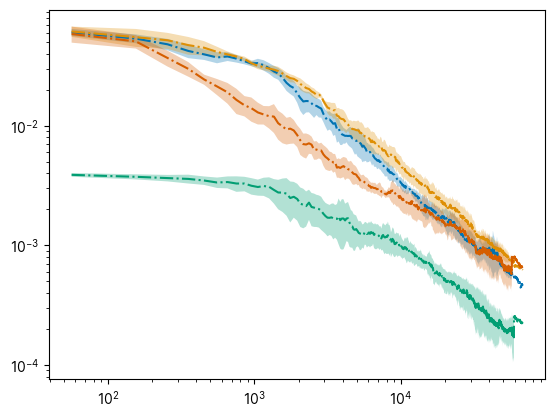

In [228]:
for i in range(4):
    plt.plot(cum_times_binned, mean_list[:, i, i], "-.")
    plt.fill_between(
        cum_times_binned,
        mean_list[:, i, i] - std_list[:, i, i],
        mean_list[:, i, i] + std_list[:, i, i],
        alpha=0.3,
    )
plt.loglog()

In [235]:
all_df = [
    big_prior_opt_results,
    small_prior_opt_results,
    big_prior_rand_results,
    small_prior_rand_results,
]
info_list = [
    "big prior opt",
    "small prior opt",
    "big prior random",
    "small prior random",
]

In [257]:
all_results_binned = [
    get_binned_results_from_runs(df_i, 200) for df_i in all_df
]

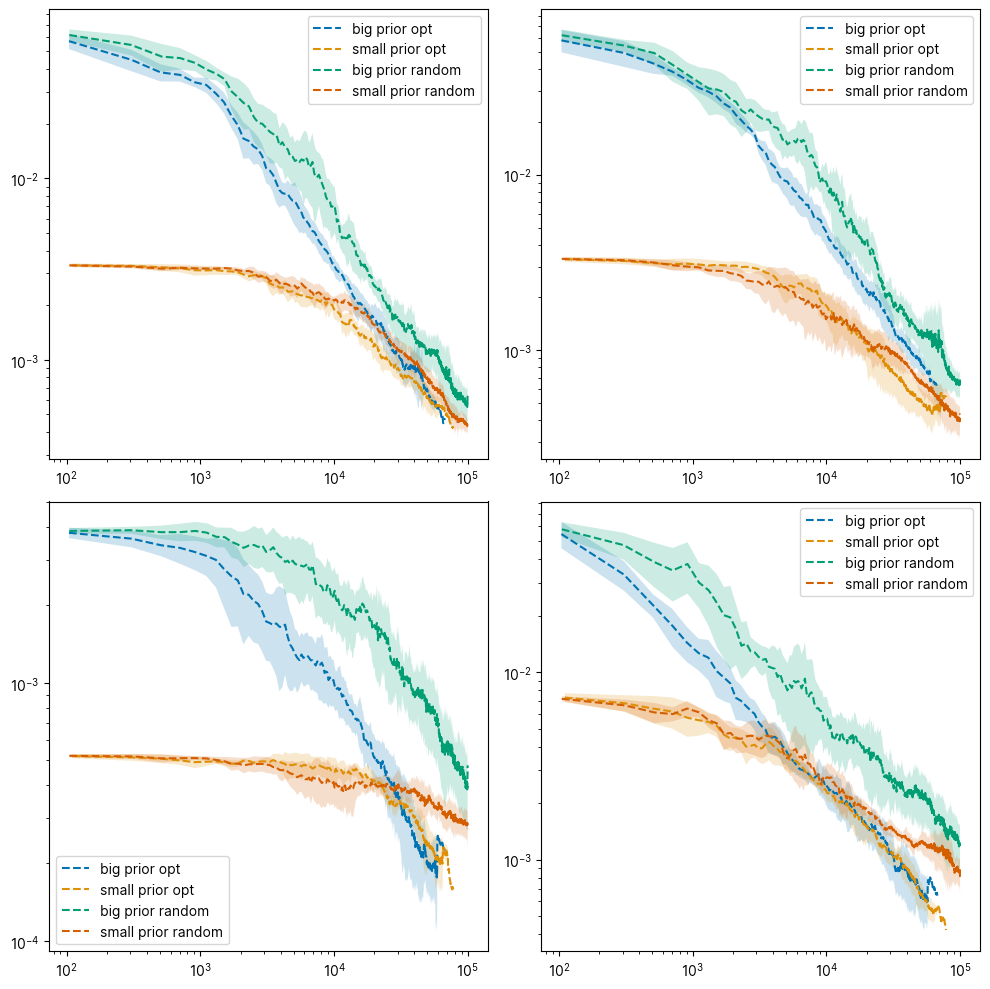

In [269]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for j, ax in enumerate(axs.flat):

    for i in range(4):
        ax.plot(
            all_results_binned[i][0],
            all_results_binned[i][1][:, j, j],
            "--",
            # ms=0.8,
            label=info_list[i],
        )
        ax.fill_between(
            all_results_binned[i][0],
            all_results_binned[i][1][:, j, j]
            + all_results_binned[i][2][:, j, j],
            all_results_binned[i][1][:, j, j]
            - all_results_binned[i][2][:, j, j],
            alpha=0.2,
        )

        #
        ax.legend()

        ax.loglog()

# plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.tight_layout()
plt.show()

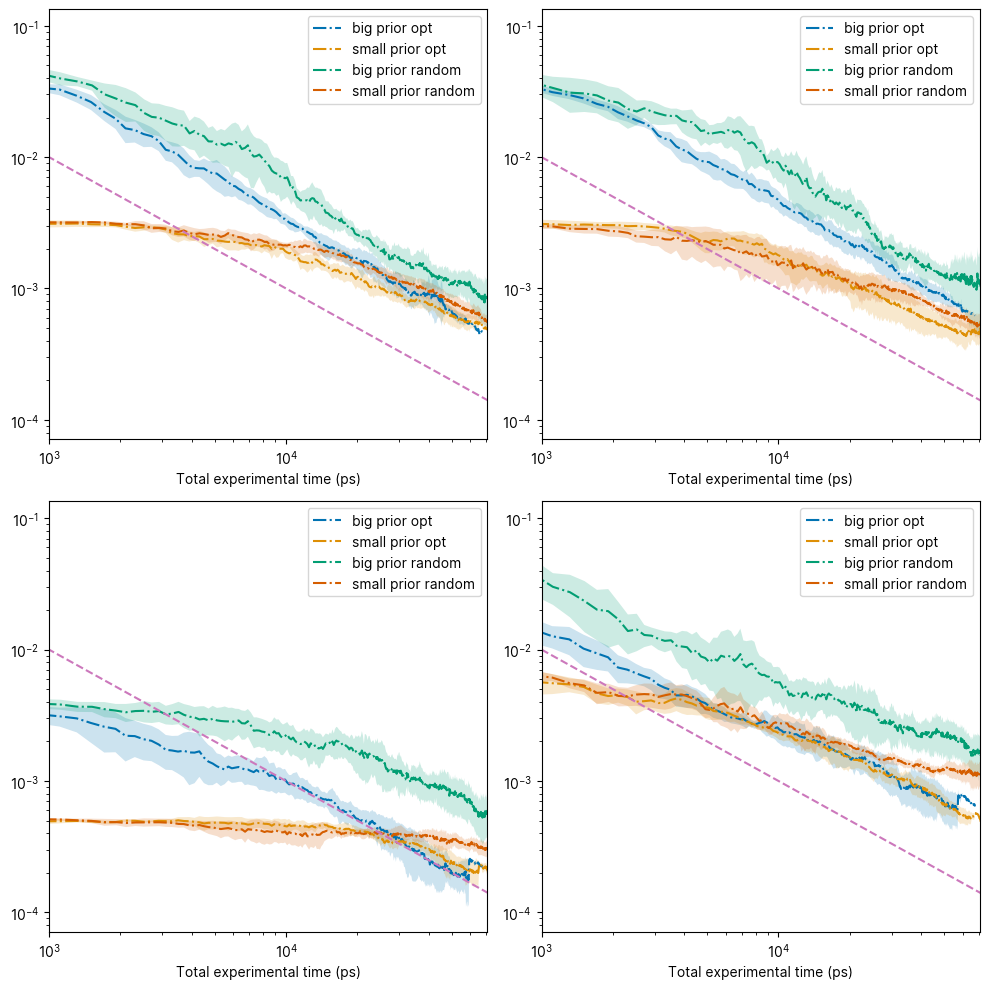

In [270]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for j, ax in enumerate(axs.flat):

    for i in range(4):
        ax.plot(
            all_results_binned[i][0],
            all_results_binned[i][1][:, j, j],
            "-.",
            # ms=0.8,
            label=info_list[i],
        )

        ax.fill_between(
            all_results_binned[i][0],
            all_results_binned[i][1][:, j, j]
            + all_results_binned[i][2][:, j, j],
            all_results_binned[i][1][:, j, j]
            - all_results_binned[i][2][:, j, j],
            alpha=0.2,
        )
        #
        ax.legend()
        ax.set_xlabel("Total experimental time (ps)")
        ax.set_xlim(1000)

    ax.plot(all_results_binned[i][0], 10 / all_results_binned[i][0], "--")
    ax.loglog()

# plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.tight_layout()
plt.show()

In [280]:
particles = np.array(arr.particles_locations[0][:, :])
weights = np.array(arr.weights[0])

In [286]:
particles[:, 0]

array([0.33713898, 0.35848066, 0.37889543, ..., 0.34442228, 0.39145318,
       0.40048626], dtype=float32)

In [288]:
np.argsort(particles[:, 0])

array([ 858, 1173, 1364, ..., 1251, 1228, 1004])

In [383]:
i = 0
sort_pars_axis = np.sort(
    particles[:, i],
)
sort_indexes = np.argsort(particles[:, i])

In [304]:
# finite_diff_weights = sort_pars_axis[1:] - weights[sort_indexes][0:-1]

# denominator_finite_diff = np.abs(
#     sort_pars_axis[1:] - np.abs(sort_pars_axis[0:-1])
# )

# finite_diff = finite_diff_weights / denominator_finite_diff

In [373]:
sort_pars_axis

array([0.28893307, 0.29236436, 0.29365298, ..., 0.45827767, 0.4587764 ,
       0.46369135], dtype=float32)

In [375]:
sort_pars_axis.shape

(2000,)

In [378]:
np.gradient(aux.pdf(particles[:, i]))

array([-6.53380239,  0.72444299,  3.95591951, ...,  1.43830965,
       -1.66085115,  0.61751535])

In [382]:
aux.pdf(sort_pars_axis)

array([0., 0., 0., ..., 0., 0., 0.])

In [381]:
sort_pars_axis

array([0.28893307, 0.29236436, 0.29365298, ..., 0.45827767, 0.4587764 ,
       0.46369135], dtype=float32)

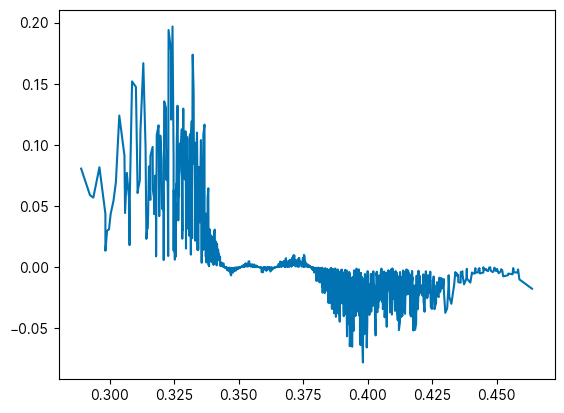

In [340]:
finite_diff_weights = (
    -weights[sort_indexes][2:]
    + 4 * weights[sort_indexes][1:-1]
    - 3 * weights[sort_indexes][0:-2]
)

denominator_finite_diff = np.abs(sort_pars_axis[2:] - (sort_pars_axis[0:-2]))

finite_diff = finite_diff_weights / denominator_finite_diff

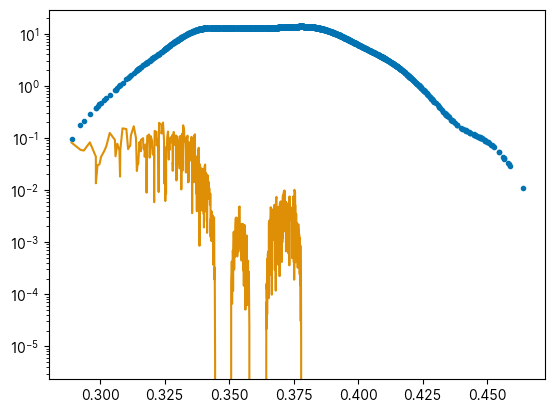

In [393]:
from scipy.stats import gaussian_kde

i = 0
aux = gaussian_kde(particles[:, i], weights=weights)
plt.plot(particles[:, i], aux.pdf(particles[:, i]), ".")

# plt.plot(particles[:, i], np.gradient(aux.pdf(particles[:, i])))\
plt.plot(sort_pars_axis, np.gradient(aux.pdf(sort_pars_axis)))
plt.yscale("log")

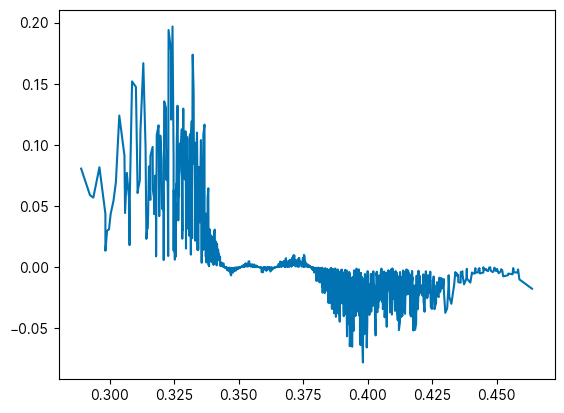

In [391]:
plt.plot(sort_pars_axis, np.gradient(aux.pdf(sort_pars_axis)))

In [358]:
aux.pdf(particles[:, 0])

array([11.55724774, 12.99472562, 13.65304391, ..., 13.01219044,
        9.84434496,  5.92959757])

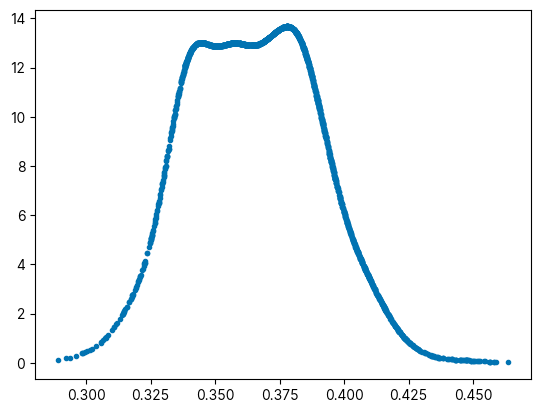

In [349]:
weights

array([1.0411928e-03, 2.0489396e-04, 8.8691292e-04, ..., 4.7467925e-04,
       5.5402599e-04, 3.6970334e-05], dtype=float32)

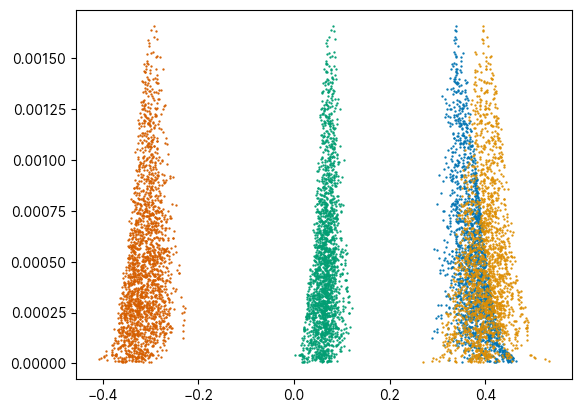

In [341]:
for i in range(4):
    plt.plot(particles[:, i], weights[:], ".", ms=1.3)

In [342]:
sort_pars_axis.shape

(2000,)

In [343]:
finite_diff.shape

(1998,)

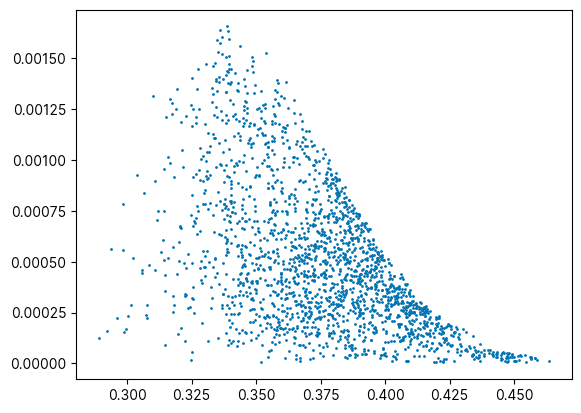

In [344]:
plt.plot(particles[:, 0], weights[:], ".", ms=2)

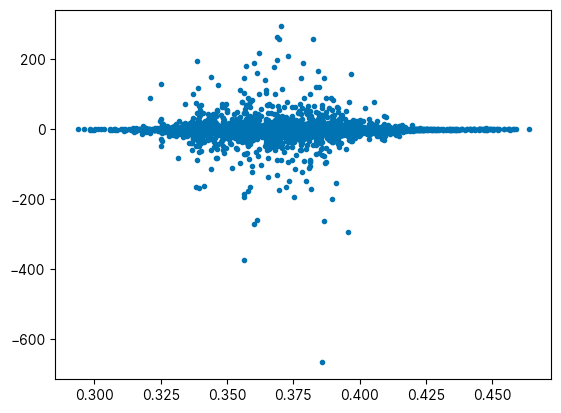

In [345]:
plt.plot(sort_pars_axis[2:], finite_diff, ".")
# plt.yscale('log')

In [305]:
finite_diff

array([  85.16904,  227.75792,  125.18177, ..., 1696.0475 ,  919.81036,
         94.34011], dtype=float32)

In [291]:
sort_pars_axis.shape

(2000,)

In [295]:
sort_pars_axis

array([0.28893307, 0.29236436, 0.29365298, ..., 0.45827767, 0.4587764 ,
       0.46369135], dtype=float32)

In [299]:
np.abs(sort_pars_axis[0:-1] - sort_pars_axis[1:])

array([0.00343129, 0.00128862, 0.00236017, ..., 0.00027019, 0.00049874,
       0.00491494], dtype=float32)

In [289]:
np.sort(
    particles[:, 0],
)

array([0.28893307, 0.29236436, 0.29365298, ..., 0.45827767, 0.4587764 ,
       0.46369135], dtype=float32)

In [281]:
particles

array([[ 0.33713898,  0.43307042,  0.08512942, -0.29017964],
       [ 0.35848066,  0.38078296,  0.02378253, -0.3380637 ],
       [ 0.37889543,  0.42055026,  0.08332042, -0.2941326 ],
       ...,
       [ 0.34442228,  0.34636754,  0.05960167, -0.33510366],
       [ 0.39145318,  0.40037778,  0.0825014 , -0.26942176],
       [ 0.40048626,  0.3498751 ,  0.07760929, -0.34405458]],
      dtype=float32)

In [276]:
arr.weights[0]

Array([1.0411928e-03, 2.0489396e-04, 8.8691292e-04, ..., 4.7467925e-04,
       5.5402599e-04, 3.6970334e-05], dtype=float32)

In [273]:
arr

Run(
  iteration=i32[5],
  key=u32[5,2],
  weights=f32[5,2000],
  particles_locations=f32[5,2000,4],
  max_iterations=i32[5],
  min_iterations=i32[5],
  std_threshold=f32[5],
  cov_array=f32[5,5000,4,4],
  estimates_array=f32[5,5000,4],
  times_array=f32[5,5000]
)

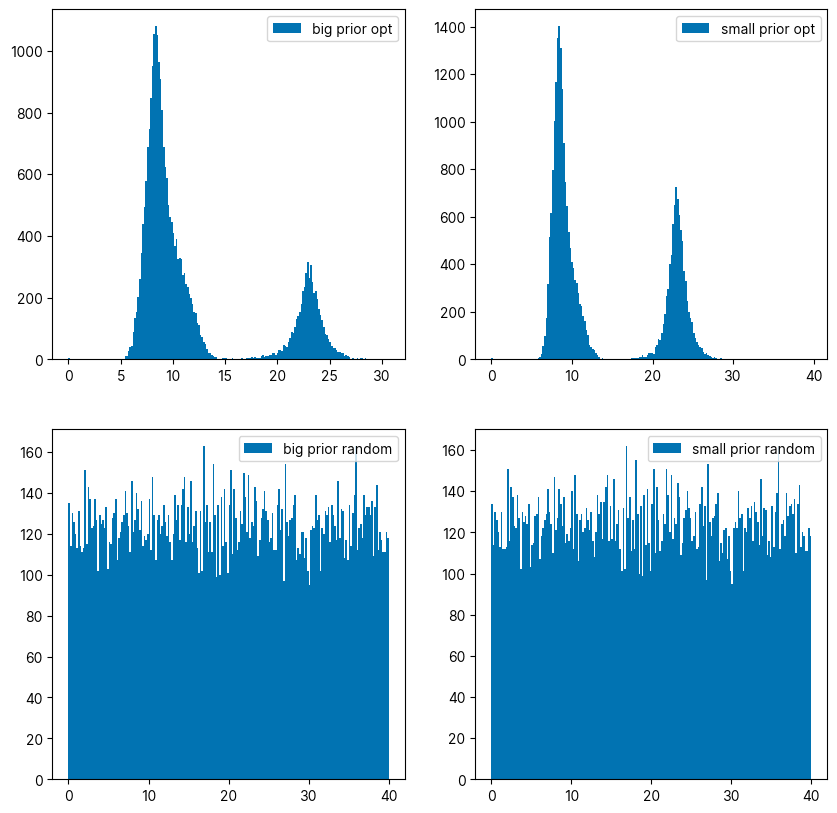

In [266]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.hist(
        np.array(all_df[i].times_array).flatten(), label=info_list[i], bins=200
    )
    ax.legend()
# plt.legend()
plt.show()